In [1]:
import numpy as np
import matplotlib.pyplot as plt

import webbpsf
from statsmodels.regression.linear_model import WLS

from lenstronomy.Data.psf import PSF
from lenstronomy.Util import util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.io import fits
from astropy.table import Table
from uncertainties import unumpy as unp
from uncertainties import ufloat
from grizli import utils
from astropy import wcs as pywcs

import pandas as pd
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.5, Om0=0.285, Ob0=0.0461)

import emcee
from scipy.optimize import minimize
from scipy import ndimage
import corner

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## Reading in the data

In [2]:
root_path = '/Users/acharyya/Work/astro/passage/'
field = 'Par028'
objid = 2867
re_limit = 2.5
Zdiag = 'NB'
filter_in_full_fits = 'F140W'

supersampling_factor = 1
fov_arcsec = 0.67
exptime = 500
filter = 'F150W'

In [3]:
survey = 'passage' if 'Par' in field else 'glass'
full_fitsname = root_path + f'/{survey}_data/v0.5/{field}/Products/maps/{field}_{objid:05d}.maps.fits'
full_hdu = fits.open(full_fitsname)
hdu = full_hdu['DSCI', filter_in_full_fits]
filter_image = hdu.data
pixel_scale = utils.get_wcs_pscale(pywcs.WCS(full_hdu['DSCI'].header))
z = full_hdu[0].header['redshift']

In [4]:
metallicity_fitsname = root_path + f'/{survey}_output/v0.5/catalogs/{field}_{objid:05d}_logOH_map_upto_{re_limit}re_onlyseg_vorbin_at_OII_SNR_3.0_Zdiag_{Zdiag}.fits'
hdul = fits.open(metallicity_fitsname)
hdu = hdul['log_OH']
logOH_map = np.ma.masked_where(np.isnan(hdu.data), unp.uarray(hdu.data, hdul['log_OH_u'].data))
logOH_map.data[np.isnan(unp.nominal_values(logOH_map.data))] = ufloat(0, 1e20)

logOH_df = Table(hdul['tab'].data).to_pandas()
logOH_df['distance'] *= cosmo.arcsec_per_kpc_proper(z).value # converting from kpc to arcsec

center_pix = int(np.shape(filter_image)[0] / 2)
farthest_pix = int(np.shape(logOH_map)[0] / 2)
light_map = filter_image[center_pix - farthest_pix : center_pix + farthest_pix, center_pix - farthest_pix : center_pix + farthest_pix]

## Use case #1: Forward-modelling the effects of psf smear

We can attempt to fit the metallicity gradient for this galaxy using weighted least squares (WLS) and the observed metallicity profile, but it won't be correct:

In [5]:
ones = np.ones(len(logOH_df))
covariates = np.vstack((ones, logOH_df['distance'])).T
wls_model_fit = WLS(logOH_df['log_OH'], covariates, weights=1/(logOH_df['log_OH_u']**2)).fit()

print(wls_model_fit.summary())

print("\nRecovered Zc = {0:.5}, gradZ = {1:.5} dex/arcsec.".format(*wls_model_fit.params))

                            WLS Regression Results                            
Dep. Variable:                 log_OH   R-squared:                       0.056
Model:                            WLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.362
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.132
Time:                        12:53:24   Log-Likelihood:                -17.761
No. Observations:                  42   AIC:                             39.52
Df Residuals:                      40   BIC:                             43.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9789      0.121     66.084      0.0

In [6]:
# ---------making the PSF---------------
niriss = webbpsf.NIRISS()
niriss.filter = filter
niriss.pixelscale = pixel_scale
psf = niriss.calc_psf(fov_arcsec=fov_arcsec, oversample=supersampling_factor)
psf_array  = psf[0].data
psf_type   = 'PIXEL'
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source':psf_array, 'point_source_supersampling_factor':supersampling_factor}

# --------generate the coordinate grid and image properties (we only read out the relevant lines we need)-----------
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=np.shape(logOH_map)[0], deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

# ---------reading in observed light map-----------------------------
kwargs_image_data = {'background_rms':.005 ,  # rms of background noise; background noise per pixel
                    'exposure_time': exptime,  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': light_map   # 2d data vector
                    }

# ---------reading in observed metallicity map-----------------------------
kwargs_tracer_data = {'noise_map': unp.std_devs(logOH_map.data),
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': unp.nominal_values(logOH_map.data)}  # 2d data vector


We can visualise this galaxy's image and metallicity map:

Text(0.5, 1.0, 'PSF')

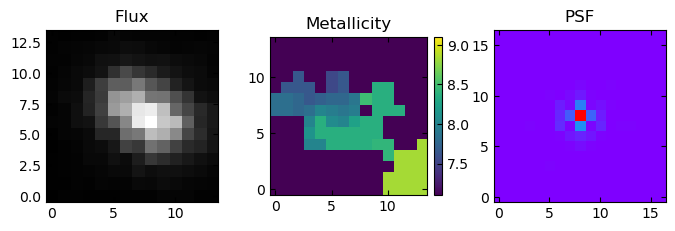

In [7]:
fig, axes = plt.subplots(1,3, figsize=(8, 3))
fig.subplots_adjust(wspace=0.3)
axes[0].imshow(kwargs_image_data['image_data'], cmap='Greys_r')
axes[0].set_title('Flux')
z_plot = axes[1].imshow(kwargs_tracer_data['image_data'], vmin=7.1, vmax=9.1)
axes[1].set_title('Metallicity')
plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.04)
axes[2].imshow(kwargs_psf['kernel_point_source'], cmap='rainbow')
axes[2].set_title('PSF')

On the other hand, we can fit the metallicity gradient using forward-modelling with `lenstronomy`'s tracer module, for a much more accurate result:  
(expected run time: ~5 minutes. Make yourself a cup of tea!)

In [7]:
# ---------defining numeric kwargs-----------------------------
kwargs_numerics = {'supersampling_factor':supersampling_factor, 
                'point_source_supersampling_factor':supersampling_factor, 
                'supersampling_convolution': True}

# ---------defining lens model-----------------------------
lens_params = [[], [], [], [], []] # Since our model is no lens, use a bunch of empty lists

# ---------defining source model params-----------------------------
# Source params -- fixed to true input values; We know that lenstronomy can fit galaxy properties, we are not testing this here.
fixed_source        = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_init  = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_sigma = [{'amp': 1,  'R_sersic': 1, 'n_sersic': 1, 'e1': 1, 'e2': 1, 'center_x': 1, 'center_y': 1}]
kwargs_lower_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_upper_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# ---------defining tracer model params-----------------------------
fixed_tracer_source = [{'center_x': 0, 'center_y': 0}]
kwargs_tracer_source_init  = [{'center_x': 0, 'center_y': 0, 'amp': 8, 'k': 0}] 
kwargs_tracer_source_sigma = [{'center_x': 2, 'center_y': 2, 'amp': 0.5, 'k': 0.3}]
kwargs_lower_tracer_source = [{'center_x': -10, 'center_y': -10, 'amp': 6,   'k': -1}]
kwargs_upper_tracer_source = [{'center_x': 10, 'center_y': 10, 'amp': 9,   'k': +1}]

tracer_source_params = [kwargs_tracer_source_init, kwargs_tracer_source_sigma, fixed_tracer_source, kwargs_lower_tracer_source, kwargs_upper_tracer_source]

# ---------combing all models-----------------------------
kwargs_params = {'lens_model': lens_params, 'source_model': source_params, 'tracer_source_model': tracer_source_params}           
kwargs_likelihood = {'source_marg': False, 'tracer_likelihood': True}
kwargs_model = {'lens_model_list': [], 'source_light_model_list': ['SERSIC_ELLIPSE'],  'tracer_source_model_list': ['LINEAR'], 'tracer_source_band': 0, 'tracer_partition':[[0,0]]}

# ---------fitting process-----------------------------
multi_band_list = [[kwargs_image_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                'multi_band_type': 'single-band',  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                'tracer_data': [kwargs_tracer_data, kwargs_psf, kwargs_numerics]}
kwargs_constraints = {'linear_solver': True}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO',  {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 100}], ['MCMC', {'n_burn': 50, 'n_run': 200, 'n_walkers': 100, 'sigma_scale': .1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print(kwargs_result)

Computing the PSO ...


100%|██████████| 100/100 [00:04<00:00, 21.81it/s]


Max iteration reached! Stopping.
-6.961760726071471 reduced X^2 of best position
-1354.0624612209012 log likelihood
389.0 effective number of data points
[] lens result
[{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}] source result
[] lens light result
[] point source result
[{'amp': 8.2150996718977, 'k': 0.9999999984161289, 'center_x': 0, 'center_y': 0}] tracer source result
{} special param result
4.588825941085815 time used for  PSO
MCMC selected. Sampling with default option emcee.


100%|██████████| 250/250 [00:18<00:00, 13.26it/s]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  50
Sampling iterations (in current run): 250
18.934640884399414 time taken for MCMC sampling
{'kwargs_lens': [], 'kwargs_source': [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': [{'amp': 8.215127554264104, 'k': 0.9999358916339155, 'center_x': 0, 'center_y': 0}]}


Much better! From the posteriors of our emcee chain we can get credible intervals and formal uncertainties on these fitted parameters, too:

In [8]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

lower_bound = np.percentile(samples_mcmc[:,1], 16)
median      = np.percentile(samples_mcmc[:,1], 50)
upper_bound = np.percentile(samples_mcmc[:,1], 84)

print("gradZ = {0:.4} (+{1:.4}/-{2:.4})".format(median, upper_bound - median, median-lower_bound))

gradZ = 0.9838 (+0.01221/-0.02631)


## Now my method of MCMC on voronoi bins

Definiing the model and likelihood functions

In [120]:
def bin_2D(value_array, id_array):
    valid_ids = id_array.data[~id_array.mask].astype(int)
    valid_values = value_array[~id_array.mask]

    unique_ids = np.unique(valid_ids)
    means = ndimage.mean(valid_values, labels=valid_ids, index=unique_ids)

    lut = np.full(int(np.nanmax(id_array.data)) + 1, np.nan)
    lut[unique_ids] = means

    result_array = np.full(id_array.shape, np.nan)
    result_array[~id_array.mask] = lut[valid_ids]

    return result_array

def compute_model(params, light_map, psf_array, bin_IDs_map):
    # -------creating metallicity profile with model parameters----------
    #logOH_map_circular = np.poly1d(radprof)(distance_map)

    # -----weighting the circular metallicity map with galaxy light profile---
    # logOH_map_model = logOH_map_circular * light_map / np.sum(light_map)
    # scale_factor = np.max(logOH_map_circular) / np.max(logOH_map_model)
    # logOH_map_model = logOH_map_model * scale_factor

    # -------creating an elliptical metallicity map--------------
    center_pix = np.array(np.shape(light_map)) / 2.
    y, x = np.indices(np.shape(light_map))
    x_rel = x - center_pix[0]
    y_rel = (y - center_pix[1]) / params[2]
    theta = np.radians(params[3])
    x_rel = x_rel * np.cos(theta) + y_rel * np.sin(theta)
    y_rel = -x_rel * np.sin(theta) + y_rel * np.cos(theta)

    distance_map = np.sqrt(x_rel ** 2 + y_rel ** 2) * pixel_scale # arcsec
    logOH_map_model = np.poly1d(params[:2])(distance_map)
    
    # ------smoothing metallicity model with PSF------------------
    logOH_map_model_smoothed = convolve(logOH_map_model, psf_array)

    # -------voronoi binning the smoothed map as per given vorbin segmentation----------
    logOH_map_model_binned = bin_2D(logOH_map_model_smoothed, bin_IDs_map)
    logOH_df_model = pd.DataFrame({'distance': distance_map.flatten(), 'log_OH_model': logOH_map_model_binned.flatten(), 'bin_ID': bin_IDs_map.data.flatten().byteswap().newbyteorder()})
    logOH_df_model = logOH_df_model.dropna().reset_index(drop=True)
    logOH_df_model['bin_ID'] = logOH_df_model['bin_ID'].astype(int)
    logOH_df_model = logOH_df_model.groupby(['bin_ID'], as_index=False).agg('mean')
    logOH_df_model = logOH_df_model.drop('bin_ID', axis=1)

    return logOH_df_model, distance_map, logOH_map_model, logOH_map_model_smoothed, logOH_map_model_binned

def log_prior(params):
    slope, cen, q, angle, log_f = params
    if -3 < slope < 3 and 6.8 < cen < 9.2 and 0 < q < 1 and 0 < angle < 180 and -5 < log_f < 0:
        return 0
    else:
        return -np.inf

def log_likelihood(params, logOH_df, light_map, psf_array, bin_IDs_map):
    lnpr = log_prior(params)
    if not np.isfinite(lnpr):
        return -np.inf
    
    x = logOH_df['distance']
    y = logOH_df['log_OH']
    yerr = logOH_df['log_OH_u']

    log_f = params[3]

    logOH_df_model, _, _, _, _= compute_model(params, light_map, psf_array, bin_IDs_map)
    temp_df = pd.DataFrame({'distance': x, 'log_OH_obs': y, 'log_OH_obs_u': yerr}) 
    logOH_df_merged = temp_df.merge(logOH_df_model, on=['distance'])
    model = logOH_df_merged['log_OH_model']

    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    log_like = -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

    return log_like

def make_plots(params):
    # ------computing the best model-----------
    logOH_df_best_model, distance_map_best, logOH_map_best_model, logOH_map_best_model_smoothed, logOH_map_best_model_binned = compute_model(params, light_map, psf_array, bin_IDs_map)

    # ------setting up figure---------
    fig2, axs = plt.subplots(2, 4, figsize=(16, 8))
    axes = axs.flatten()
    fig2.subplots_adjust(wspace=0.5, hspace=0.)

    # --------plotting 2D maps----------
    axes[0].imshow(light_map, cmap='Greys_r')
    axes[0].set_title('Flux data')

    z_plot = axes[1].imshow(np.ma.masked_where(logOH_map.mask, unp.nominal_values(logOH_map)), vmin=7.1, vmax=9.1)
    axes[1].set_title('Metallicity data')
    plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.01)

    axes[2].imshow(psf_array, cmap='rainbow')
    axes[2].set_title('PSF')

    z_plot = axes[3].imshow(distance_map_best)
    axes[3].set_title('Distance\nbest model')
    plt.colorbar(z_plot,ax=axes[3],fraction=0.046, pad=0.01)

    z_plot = axes[4].imshow(logOH_map_best_model, vmin=7.1, vmax=9.1)
    axes[4].set_title('Metallicity\nbest model')
    plt.colorbar(z_plot,ax=axes[4],fraction=0.046, pad=0.01)

    z_plot = axes[5].imshow(logOH_map_best_model_smoothed, vmin=7.1, vmax=9.1)
    axes[5].set_title('Metallicity\nbest model smoothed')
    plt.colorbar(z_plot,ax=axes[5],fraction=0.046, pad=0.01)

    z_plot = axes[6].imshow(logOH_map_best_model_binned, vmin=7.1, vmax=9.1)
    axes[6].set_title('Metallicity\nbest model binned')
    plt.colorbar(z_plot,ax=axes[6],fraction=0.046, pad=0.01)

    # -------plotting radial profiles--------------
    # gs = axes[-2].get_gridspec()
    # axes[-2].remove()
    # axes[-1].remove()
    # radprof_ax = fig.add_subplot(gs[1, -2:])
    radprof_ax = axes[7]
    xarr = np.linspace(np.min(logOH_df['distance']), np.max(logOH_df['distance']), 10)

    radprof_ax.errorbar(logOH_df['distance'], logOH_df['log_OH'], yerr=logOH_df['log_OH_u'], fmt='.k', capsize=0)
    radprof_ax.plot(xarr, np.poly1d([wls_model_fit.params['x1'], wls_model_fit.params['const']])(xarr), c='k', ls='--', label='WLS fit')
    radprof_ax.plot(xarr, np.poly1d(params[:2])(xarr), c='maroon', ls=':', label='this model')
    radprof_ax.scatter(logOH_df_best_model['distance'], logOH_df_best_model['log_OH_model'], c='salmon', s=30, lw=0.5, ec='k', label='best model\nbinned', zorder=5)

    radprof_ax.set_xlabel('radius (arcsec)')
    radprof_ax.set_ylabel(f'log O/H + 12 ({Zdiag})')
    radprof_ax.legend()
    radprof_ax.set_aspect('auto')

    return fig


Declaring emcee parameters and other static arguments

In [128]:
bin_IDs_map = hdul['bin_id'].data
bin_IDs_map = np.ma.masked_where(np.isnan(bin_IDs_map), bin_IDs_map)

params_init = [-0.5, 8, 0.7, 45, -1] # [slope, Z_cen, q=1-ellipticity, position angle in deg, log_f]
bounds = [(-3, 3), (7, 9), (0.01, 1), (0, 180), (-5, 0)]
#bounds = [(None, None), (None, None), (0.1, 1), (None, None), (None, None)]
ndim = len(params_init)
nwalkers = 32
niter = 5000

Visualising how the initial guess

In [ ]:
fig_init = make_plots(params_init)

Running maximum-likelihood estimation with scipy

In [ ]:
nll = lambda *args: -log_likelihood(*args)
#soln = minimize(nll, params_init, args=(logOH_df, light_map, psf_array, bin_IDs_map), options={'maxiter': niter, 'disp': True})
soln = minimize(nll, params_init, bounds=bounds, args=(logOH_df, light_map, psf_array, bin_IDs_map), options={'maxiter': niter, 'disp': True})
print(soln.x)

Visualising the scipy results, along with the data

In [ ]:
fig_scipy = make_plots(soln.x)

Running MCMC using the scipy solutions as a starting point

In [ ]:
pos = params_init + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(logOH_df, light_map, psf_array, bin_IDs_map))
dummy = sampler.run_mcmc(pos, niter, progress=True)

 25%|██▌       | 1272/5000 [02:11<07:05,  8.76it/s]

Visualising the MCMC results as corner plots

{'slope': -0.5376699570417807, 'cen': 7.8803182161664145, 'q': 0.41158249483872544, 'angle': 0.9188246610203645, 'log(f)': -2.6661313623689136}


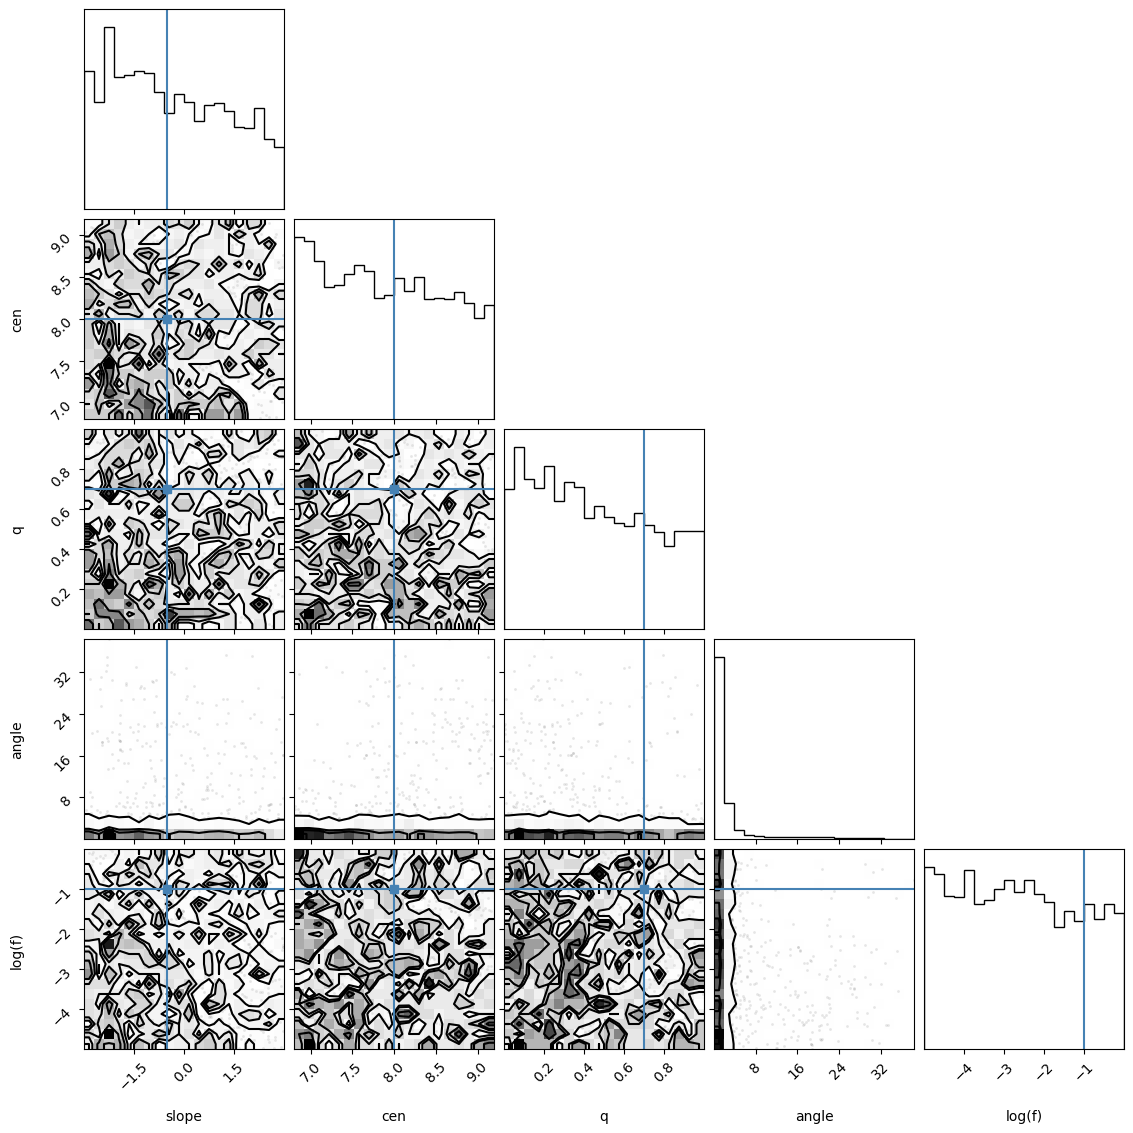

In [126]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ['slope', 'cen', 'q', 'angle', 'log(f)']
fig_corner = corner.corner(flat_samples, labels=labels, truths=params_init)

best_fit_params = [np.median(flat_samples[:, item]) for item in range(np.shape(flat_samples)[1])]
print(dict(zip(labels, best_fit_params)))

Visualising the MCMC results along with the data

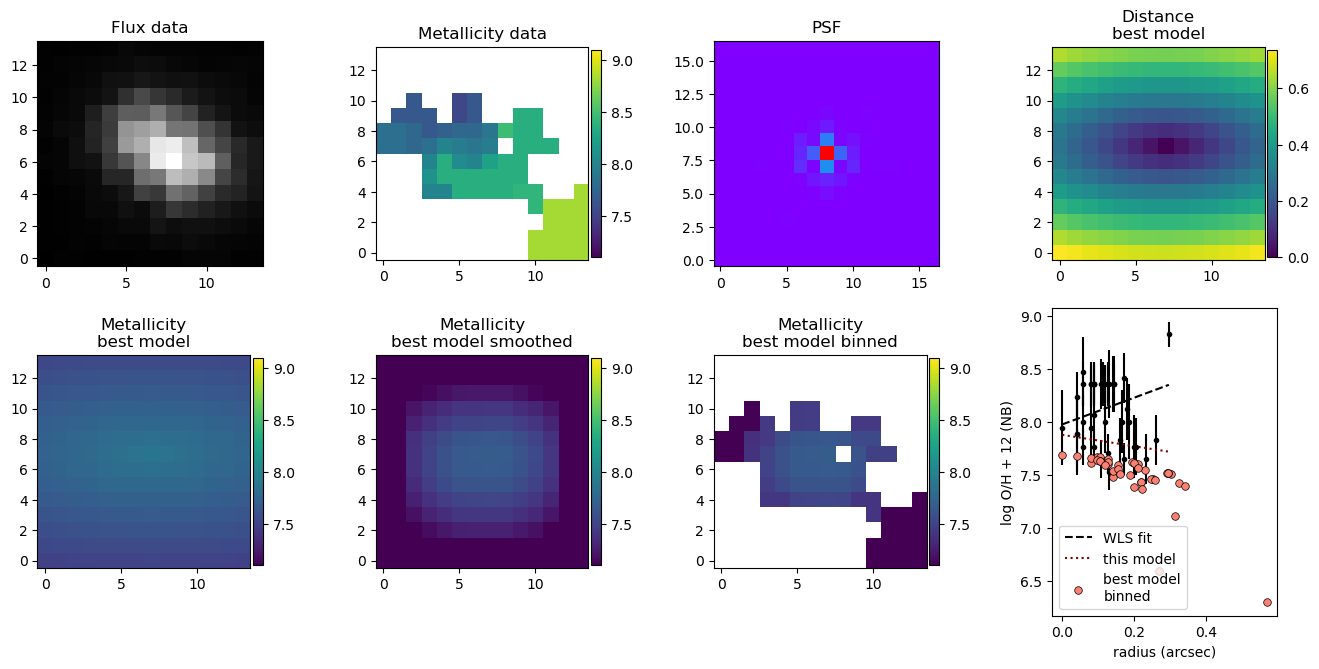

In [127]:
fig_mcmc = make_plots(best_fit_params)